##Read the Dataset and Prepare Validation Framework



In [1]:
data = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"


In [2]:
!wget  $data -O data-hw-4.csv

--2023-10-04 10:58:37--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data-hw-4.csv’

data-hw-4.csv       100%[===================>]   1.41M  --.-KB/s    in 0.02s   

2023-10-04 10:58:38 (61.3 MB/s) - ‘data-hw-4.csv’ saved [1475504/1475504]



In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
df = pd.read_csv('data-hw-4.csv')

In [4]:
df = df[['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style', 'highway MPG','city mpg','MSRP']]

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df = df.fillna(0)
df.isna().sum()


make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [6]:
mean_msrp=df['msrp'].mean()
df['above_average']= (df['msrp']>mean_msrp).astype(int)


In [7]:
X=df.drop(['msrp','above_average'], axis=1)
y = df[['above_average']].values

In [8]:
X_full_train,X_test, y_full_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)

In [9]:
X_full_train.shape

(9531, 9)

In [10]:
y_full_train.shape

(9531, 1)

In [11]:
X_train,X_val, y_train, y_val =  train_test_split(X_full_train,y_full_train, test_size=0.25,random_state=1)

In [12]:
X_train.shape

(7148, 9)

In [13]:
y_train.shape

(7148, 1)

##Q.1

In [17]:
X_train.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
dtype: object

In [19]:
numerical_columns = list(X_train.dtypes[(df.dtypes == 'int64')|(df.dtypes == 'float64')].index)
numerical_columns

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [20]:
from sklearn.metrics import roc_auc_score


In [33]:
for c in numerical_columns:
  print("column = ",c,", roc auc score = ",roc_auc_score( y_train,X_train[[c]]))


column =  year , roc auc score =  0.687551492804683
column =  engine_hp , roc auc score =  0.9171031265539011
column =  engine_cylinders , roc auc score =  0.766116490165669
column =  highway_mpg , roc auc score =  0.3669412128227987
column =  city_mpg , roc auc score =  0.3265755356754767


In [37]:
for c in numerical_columns:
  auc_score = roc_auc_score( y_train,X_train[[c]])
  if (auc_score<0.5):
    print(c, " <0.5")
    auc_score= roc_auc_score( y_train,-X_train[[c]])
  print("column = ",c,", roc auc score = ",auc_score)

column =  year , roc auc score =  0.687551492804683
column =  engine_hp , roc auc score =  0.9171031265539011
column =  engine_cylinders , roc auc score =  0.766116490165669
highway_mpg  <0.5
column =  highway_mpg , roc auc score =  0.6330587871772013
city_mpg  <0.5
column =  city_mpg , roc auc score =  0.6734244643245233


##Q.2

In [40]:
def train(X_train, y_train):
    dicts = X_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [41]:
dv, model = train(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
def predict(X_val, dv, model):
    dicts = X_val.to_dict(orient='records')

    X_val = dv.transform(dicts)
    y_pred = model.predict_proba(X_val)[:, 1]

    return y_pred

In [45]:
y_pred = predict(X_val, dv, model)


In [73]:
round(roc_auc_score(y_val.reshape(-1),y_pred),4)

0.9797

In [65]:
len(y_pred)

2383

##Q.3

In [88]:
scores = []
thresholds = np.arange(start=0, stop=1, step=0.01)

for t in thresholds:

    actual_positive = (y_val.reshape(-1) == 1)
    actual_negative = (y_val.reshape(-1) == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [89]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)

In [90]:
import matplotlib.pyplot as plt

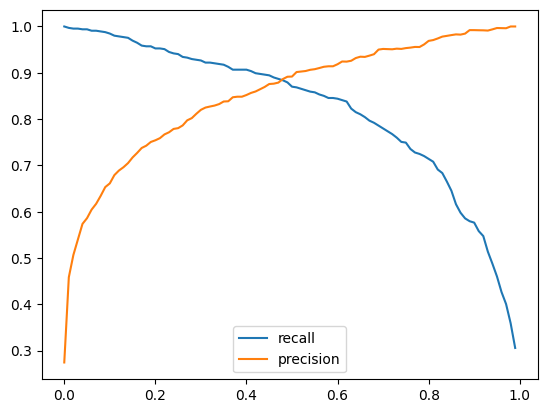

In [91]:
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.legend()

##Q.4

In [92]:
df_scores['f1_score']= (2*df_scores['recall']*df_scores['precision'])/(df_scores['recall']+df_scores['precision'])

In [93]:
df_scores['f1_score'].max()

0.8852963818321786

In [94]:
max_index=df_scores['f1_score'].idxmax()
max_index

49

In [95]:
df_scores.threshold.iloc[max_index]

0.49

In [96]:
df_scores[df_scores.threshold==0.52].f1_score

52    0.883685
Name: f1_score, dtype: float64

In [97]:
df_scores[df_scores.threshold==0.32].f1_score

32    0.872017
Name: f1_score, dtype: float64

In [98]:
df_scores[df_scores.threshold==0.72].f1_score

72    0.849408
Name: f1_score, dtype: float64

In [99]:
df_scores[df_scores.threshold==0.12].f1_score

12    0.808591
Name: f1_score, dtype: float64

##Q.5

In [100]:
from sklearn.model_selection import KFold

In [101]:
from tqdm.auto import tqdm


In [108]:
kfold =KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(X_full_train):
  df_train = X_full_train.iloc[train_idx]
  df_val = X_full_train.iloc[val_idx]

  y_train = y_full_train[train_idx].reshape(-1)
  y_val = y_full_train[val_idx].reshape(-1)

  dv, model = train(df_train, y_train)
  y_pred = predict(df_val, dv, model)

  auc = roc_auc_score(y_val, y_pred)
  scores.append(auc)

print(' %.3f +- %.3f' % (np.mean(scores), np.std(scores)))


 0.979 +- 0.002


##Q.6

In [105]:
def train_params(X_train, y_train, c):
    dicts = X_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [107]:
n_splits=5

# C = regularization parameter for the model
# tqdm() is a function that prints progress bars
for C in tqdm([0.01, 0.1, 0.5, 10]):

  kfold =KFold(n_splits=n_splits, shuffle=True, random_state=1)

  scores = []

  for train_idx, val_idx in kfold.split(X_full_train):
    df_train = X_full_train.iloc[train_idx]
    df_val = X_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx].reshape(-1)
    y_val = y_full_train[val_idx].reshape(-1)

    dv, model = train_params(df_train, y_train, C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

  print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))



  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.952 +- 0.003
C=0.1 0.972 +- 0.002
C=0.5 0.977 +- 0.002
C=10 0.981 +- 0.003
